# Thin airfoil theory visualised

Here we'll try to use the basic function we wrote for vortex flow to try and visulaise the thin airfoil theory to get the hang of it!
let's start with importing all the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from base_flows import vortex,uniform

We'll model the flow over a symmetric airofil with atrailing edge flap that can change it's angle denoted ad $\beta$, let's plot and example of the camber line with $\beta=10^\circ$:

(-0.1, 0.1)

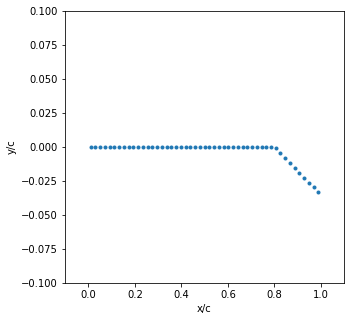

In [2]:
c=1
alpha=np.deg2rad(0)
beta=np.deg2rad(10)
x_airfoil=np.linspace(0,1,50)
x_centers=(x_airfoil[1:] + x_airfoil[:-1]) / 2
z_airfoil=-np.tan(beta)*(x_centers-0.8)
z_airfoil[x_centers<0.8]=0
plt.figure(figsize=(5,5))
plt.plot(x_centers,z_airfoil,marker='.',ls='')
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,0.1)

Thin airfoil theory makes alot of use with the transformation:
$$
x/c=\frac{1}{2}(1-cos\theta)
$$ 
Thus it will be necessary to implement this transformation in both directions:

In [3]:
def theta2x(theta):
    return 0.5*(1-np.cos(theta))
def x2theta(x):
    return np.arccos(1-2*x)

From the class notes considering a cambered thin airfoil the vorticity distribution along the cord is given by:
$$\gamma(\theta)=2V_{\inf}\big(A_0\frac{1+cos\theta}{sin\theta}+\sum_{n=1}^\inf A_nsin(n\cdot\theta)\big)$$

Where the coefcients $A_n$ are the given by:
$$
A_0=\alpha-\frac{1}{\pi}\int_0^\pi \frac{dz}{dx}d\theta_0 \\
A_n=\frac{2}{\pi}\int_0^\pi \frac{dz}{dx}cos(n\cdot\theta_0)d\theta_0
$$
Keep in mind that $\frac{dz}{dx}$ is a function of $\theta_0$!
In our case,
$$
\frac{dz}{dx}=\begin{cases}
0, &\text{x/c<0.8} \\
-tan(\beta), &x/c\geq 0.8
\end{cases}
$$
thus,
$$
A_n=\frac{2}{\pi}\int_{0.7\pi}^\pi -tan(\beta)cos(n\cdot\theta_0)d\theta_0 =\frac{2}{\pi}tan(\beta)\frac{1}{n}sin(n\cdot0.7\pi)\approx\frac{2}{\pi}\beta\frac{1}{n}sin(n\cdot0.7\pi)
$$



In [4]:
def An(n,beta,alpha):
    A=2/np.pi*beta/n*np.sin(n*x2theta(0.8))
    A[0]=alpha+beta
    return A

In [5]:

n=np.arange(100)
A=An(n,beta,alpha)



/opt/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Now we can calculate the vorticity distribution $\gamma(\theta)$:

In [6]:
gamma=[]
Vinf=1
for xc in x_centers:
    theta=x2theta(xc)
    gamma.append(2*Vinf*(A[0]*(1+np.cos(theta))/np.sin(theta)+np.sum(A[1::]*np.sin(n[1::]*theta))))
gamma=np.array(gamma)

Let's plot it to see if kutta condition is satisfied, $\gamma(\pi)=0$:

Text(0.5, 0, '$x/c$')

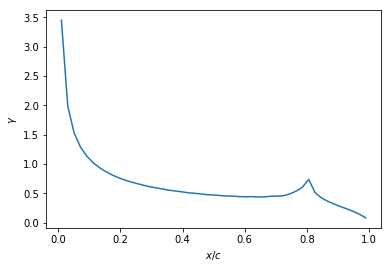

In [7]:
plt.plot(x_centers,gamma)
plt.ylabel(r'$\gamma$')
plt.xlabel(r'$x/c$')

Seems right! if we'll increase our resolution will get to 0. 
Now wee need to construct our domain for the streamline calculations:

In [20]:
N = 500                               # number of points in each direction
x_start, x_end = -2.0, 2.0            # boundaries in the x-direction
y_start, y_end = -1,1       # boundaries in the y-direction
x = np.linspace(x_start, x_end, N)    # creates a 1D-array with the x-coordinates
y = np.linspace(y_start, y_end, N)    # creates a 1D-array with the y-coordinates
X, Y = np.meshgrid(x, y)              # generates a mesh grid

We'll make use of the `vortex` library we created and distribute vortexes with circulation strength of $\gamma(\theta_i)ds_i$, making use of the superposition in potential flow theory

In [21]:
u_vortex,v_vortex,psi_vortex=0,0,0
for i,xc in enumerate(x_centers):
    theta=x2theta(xc)
    strength=gamma[i]*np.diff(x)[i]
    u,v=vortex.get_velocity(strength,xc,z_airfoil[i],X,Y)
    psi=vortex.get_stream_function(strength,xc,z_airfoil[i],X,Y)
    u_vortex+=u
    v_vortex+=v
    psi_vortex+=psi

In [22]:
u_free,v_free=uniform.get_velocity(Vinf,X,Y)
psi_free=uniform.get_stream_function(Vinf,X,Y)

(-0.5, 0.5)

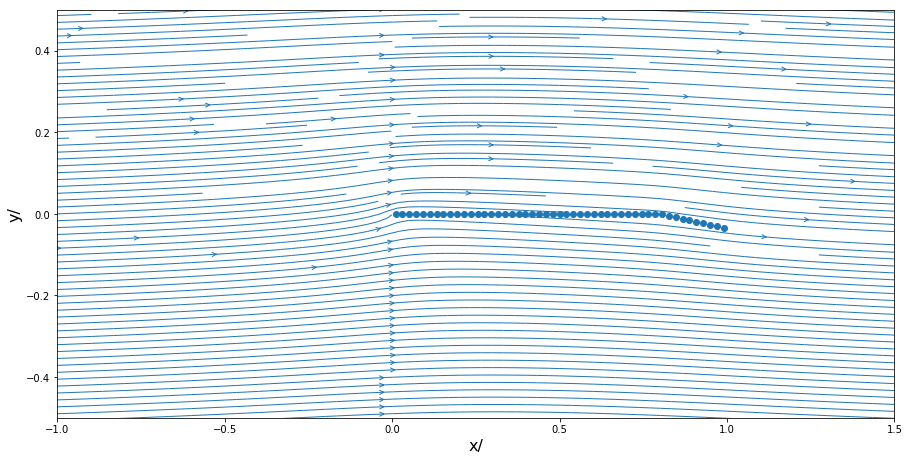

In [27]:
# superposition of the source on the freestream
u = u_free*np.cos(alpha)+ u_vortex
v = v_free*np.sin(alpha) + v_vortex
psi = psi_free + psi_vortex

# plot the streamlines
width = 10
height = (y_end - y_start) / (x_end - x_start) * width
plt.figure(figsize=(width*1.5, height*1.5))
plt.xlabel('x/', fontsize=16)
plt.ylabel('y/', fontsize=16)
plt.streamplot(X, Y, u, v, density=4, linewidth=1, arrowsize=1, arrowstyle='->')

plt.scatter(x_centers,z_airfoil)
plt.xlim(-1,1.5)
plt.ylim(-0.5,0.5)